In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
df = pd.read_csv("/content/drive/MyDrive/Serangan Jantung/balanced_output_data.csv")

In [44]:
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,49,1,1,130,266,0,1,171,0,0.600000,2,0,2,1
1,55,1,0,140,217,0,1,111,1,5.600000,0,0,3,0
2,31,0,0,151,523,1,0,195,1,1.054641,2,0,2,0
3,54,0,2,135,304,1,1,170,0,0.000000,2,0,2,1
4,61,0,2,97,165,0,0,98,1,0.171405,2,4,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,29,1,1,130,204,0,0,202,0,0.000000,2,0,2,1
1976,51,1,0,183,264,0,0,162,1,2.457638,0,4,2,1
1977,53,0,3,104,509,1,0,118,1,4.276736,0,1,0,0
1978,55,1,1,130,262,0,1,155,0,0.000000,2,0,2,1


In [45]:
#df['bmi'].fillna(df['bmi'].mean(), inplace=True)

In [46]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['oldpeak','caa']

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    df[column] = label_encoders[column].fit_transform(df[column])

In [47]:
# Membagi dataset menjadi fitur (X) dan label (y)
X = df.drop(['oldpeak','caa'], axis=1)
y = df['output']

In [48]:
# Normalisasi fitur numerik
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [49]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [50]:
# Reshape the input data for CNN (1D Convolution requires 3D input: samples, timesteps, features)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [51]:
# One-hot encode label
#y_train = to_categorical(y_train, num_classes=2)
#y_test = to_categorical(y_test, num_classes=2)

In [52]:
# Build the CNN model
model = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),  # MODIFIKASI: Menambahkan dropout setelah pooling
    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # MODIFIKASI: Tambahkan regularisasi L2
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
# Tambahkan Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # MODIFIKASI

In [55]:
# Train the model
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]  # MODIFIKASI: Callback untuk early stopping
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.5816 - loss: 1.4696 - val_accuracy: 0.8687 - val_loss: 1.0797
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7729 - loss: 1.0189 - val_accuracy: 0.9091 - val_loss: 0.7361
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8442 - loss: 0.7408 - val_accuracy: 0.9242 - val_loss: 0.5307
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8762 - loss: 0.5716 - val_accuracy: 0.9343 - val_loss: 0.4183
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8958 - loss: 0.4720 - val_accuracy: 0.9343 - val_loss: 0.3492
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9179 - loss: 0.4020 - val_accuracy: 0.9747 - val_loss: 0.3030
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9165 - loss: 0.3777 - val_accuracy: 0.9823 - val_loss: 0.2556
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9177 - loss: 0.3476 - val_accuracy: 0.9697 - val_loss

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


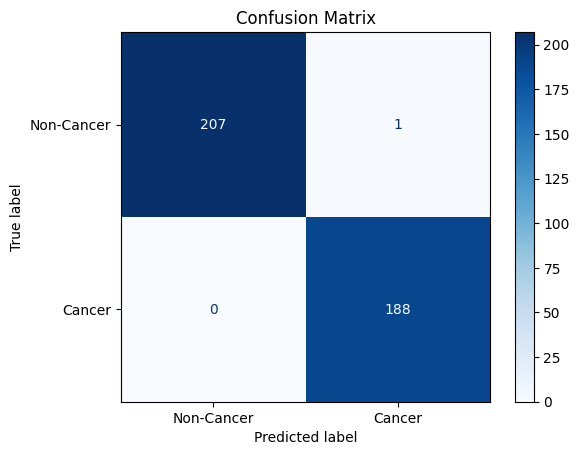

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prediksi data pengujian
y_pred = (model.predict(X_test_cnn) > 0.5).astype("int32")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancer', 'Cancer'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


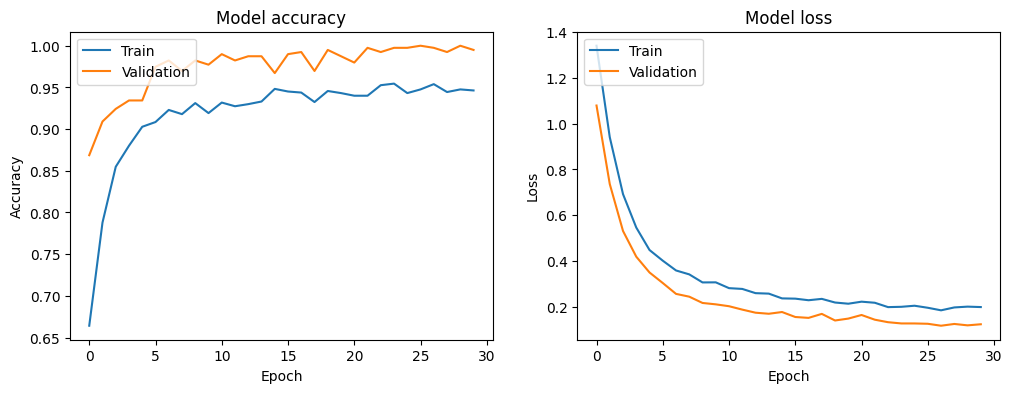

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       208
           1       0.97      1.00      0.99       188

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [57]:
# Predict the labels for the test set
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.4).astype(int)

# Display validation accuracy and validation loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Print classification report for additional metrics
print(classification_report(y_test, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


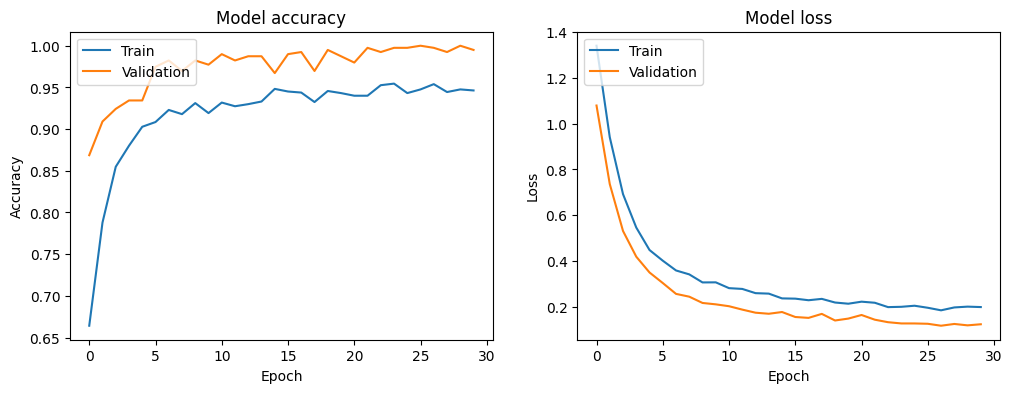

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       208
           1       0.97      1.00      0.99       188

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [58]:
# Predict the labels for the test set
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.4).astype(int)

# Display validation accuracy and validation loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Import classification_report
from sklearn.metrics import classification_report # Importing the necessary function

# Print classification report for additional metrics
print(classification_report(y_test, y_pred))

In [59]:
# Print classification report for additional metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       208
           1       0.97      1.00      0.99       188

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


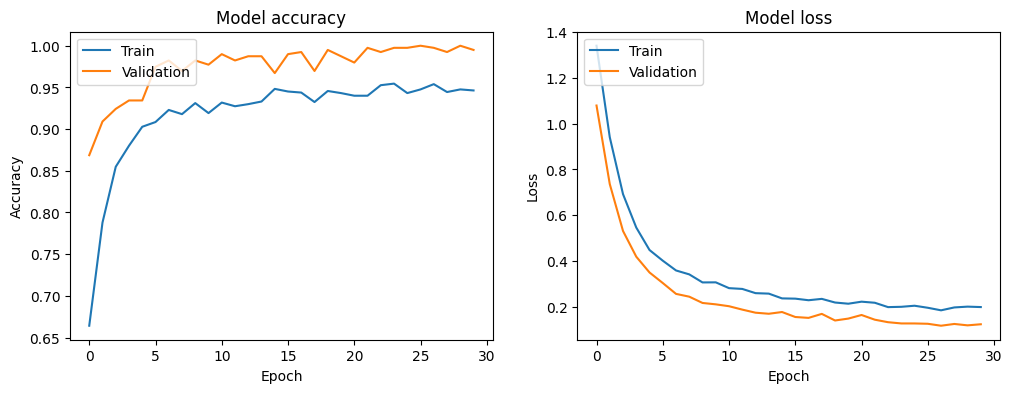

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       208
           1       0.97      1.00      0.99       188

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [60]:
# Predict the labels for the test set
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.4).astype(int)

# Display validation accuracy and validation loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Import classification_report
from sklearn.metrics import classification_report # Importing the necessary function

# Print classification report for additional metrics
print(classification_report(y_test, y_pred))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


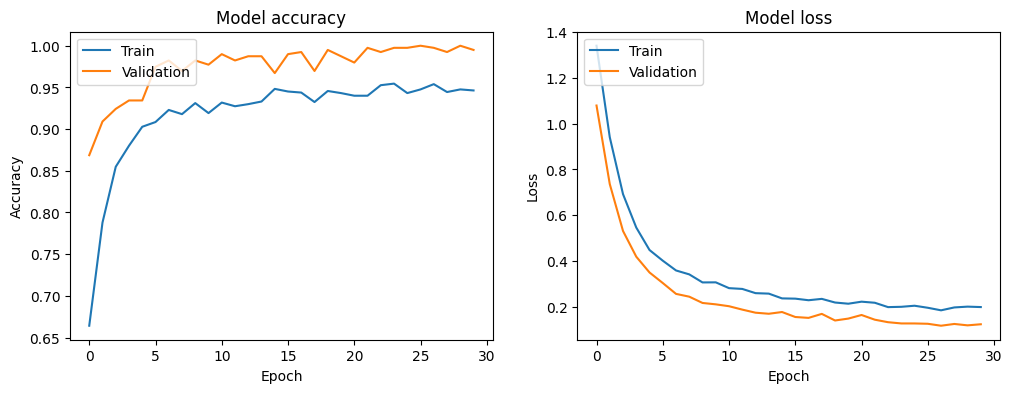

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       208
           1       0.97      1.00      0.99       188

    accuracy                           0.99       396
   macro avg       0.99      0.99      0.99       396
weighted avg       0.99      0.99      0.99       396



In [61]:
# Predict the labels for the test set
y_pred_prob = model.predict(X_test_cnn)
y_pred = (y_pred_prob > 0.4).astype(int)

# Display validation accuracy and validation loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Import classification_report
from sklearn.metrics import classification_report

# Print classification report for additional metrics
print(classification_report(y_test, y_pred))

In [62]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

[[203   5]
 [  0 188]]
